In [1]:
# import dependencies

import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import requests
import scipy.stats as st


In [2]:
# read excel file downloaded from kaggle
df=pd.read_excel("./Business_dataset.xlsx")

# drop any incomplete data
df=df.dropna()


In [3]:
# Get Revenue by Country
country_grp=df.groupby("ship to country").sum()["Revenue"]
country_df=pd.DataFrame(country_grp)

# Add a column to store Revenue divided by 1 million to make charts easier to read
country_df["RevIn1000000s"] = country_df["Revenue"]/1000000


In [4]:
# import a csv file of Country and ISO code
country_api_df = pd.read_csv("./iso_country.csv")

# merge the country revenue data and iso data into a new dataframe
population_df = pd.merge(country_df,country_api_df,on=["ship to country"],how="left")


In [5]:
# set up api call to get population for the countries
url = "http://api.worldbank.org/v2/"
api_format = "json"

# add column to store population
population_df["Population"] = ""

# loop through each country and make call to api to return the population
for index, row in population_df.iterrows():
    try:
        pop_response = requests.get(f"{url}country/{row['ISO']}/indicator/SP.POP.TOTL?date=2015&format={api_format}").json()
        population_df.loc[index,"Population"] = pop_response[1][0]["value"]
    except:
        # Population data is not available for Taiwan, Found data on multiple web sites and added to dataframe
        print(f"{url}country/{row['ISO']}/indicator/SP.POP.TOTL?date=2015&format={api_format}")
        print(f"Not Found:{row['ship to country']}")
        population_df.loc[index,"Population"] = 23492000


http://api.worldbank.org/v2/country/TW/indicator/SP.POP.TOTL?date=2015&format=json
Not Found:Taiwan


The correlation between Population and Revenue is 0.65


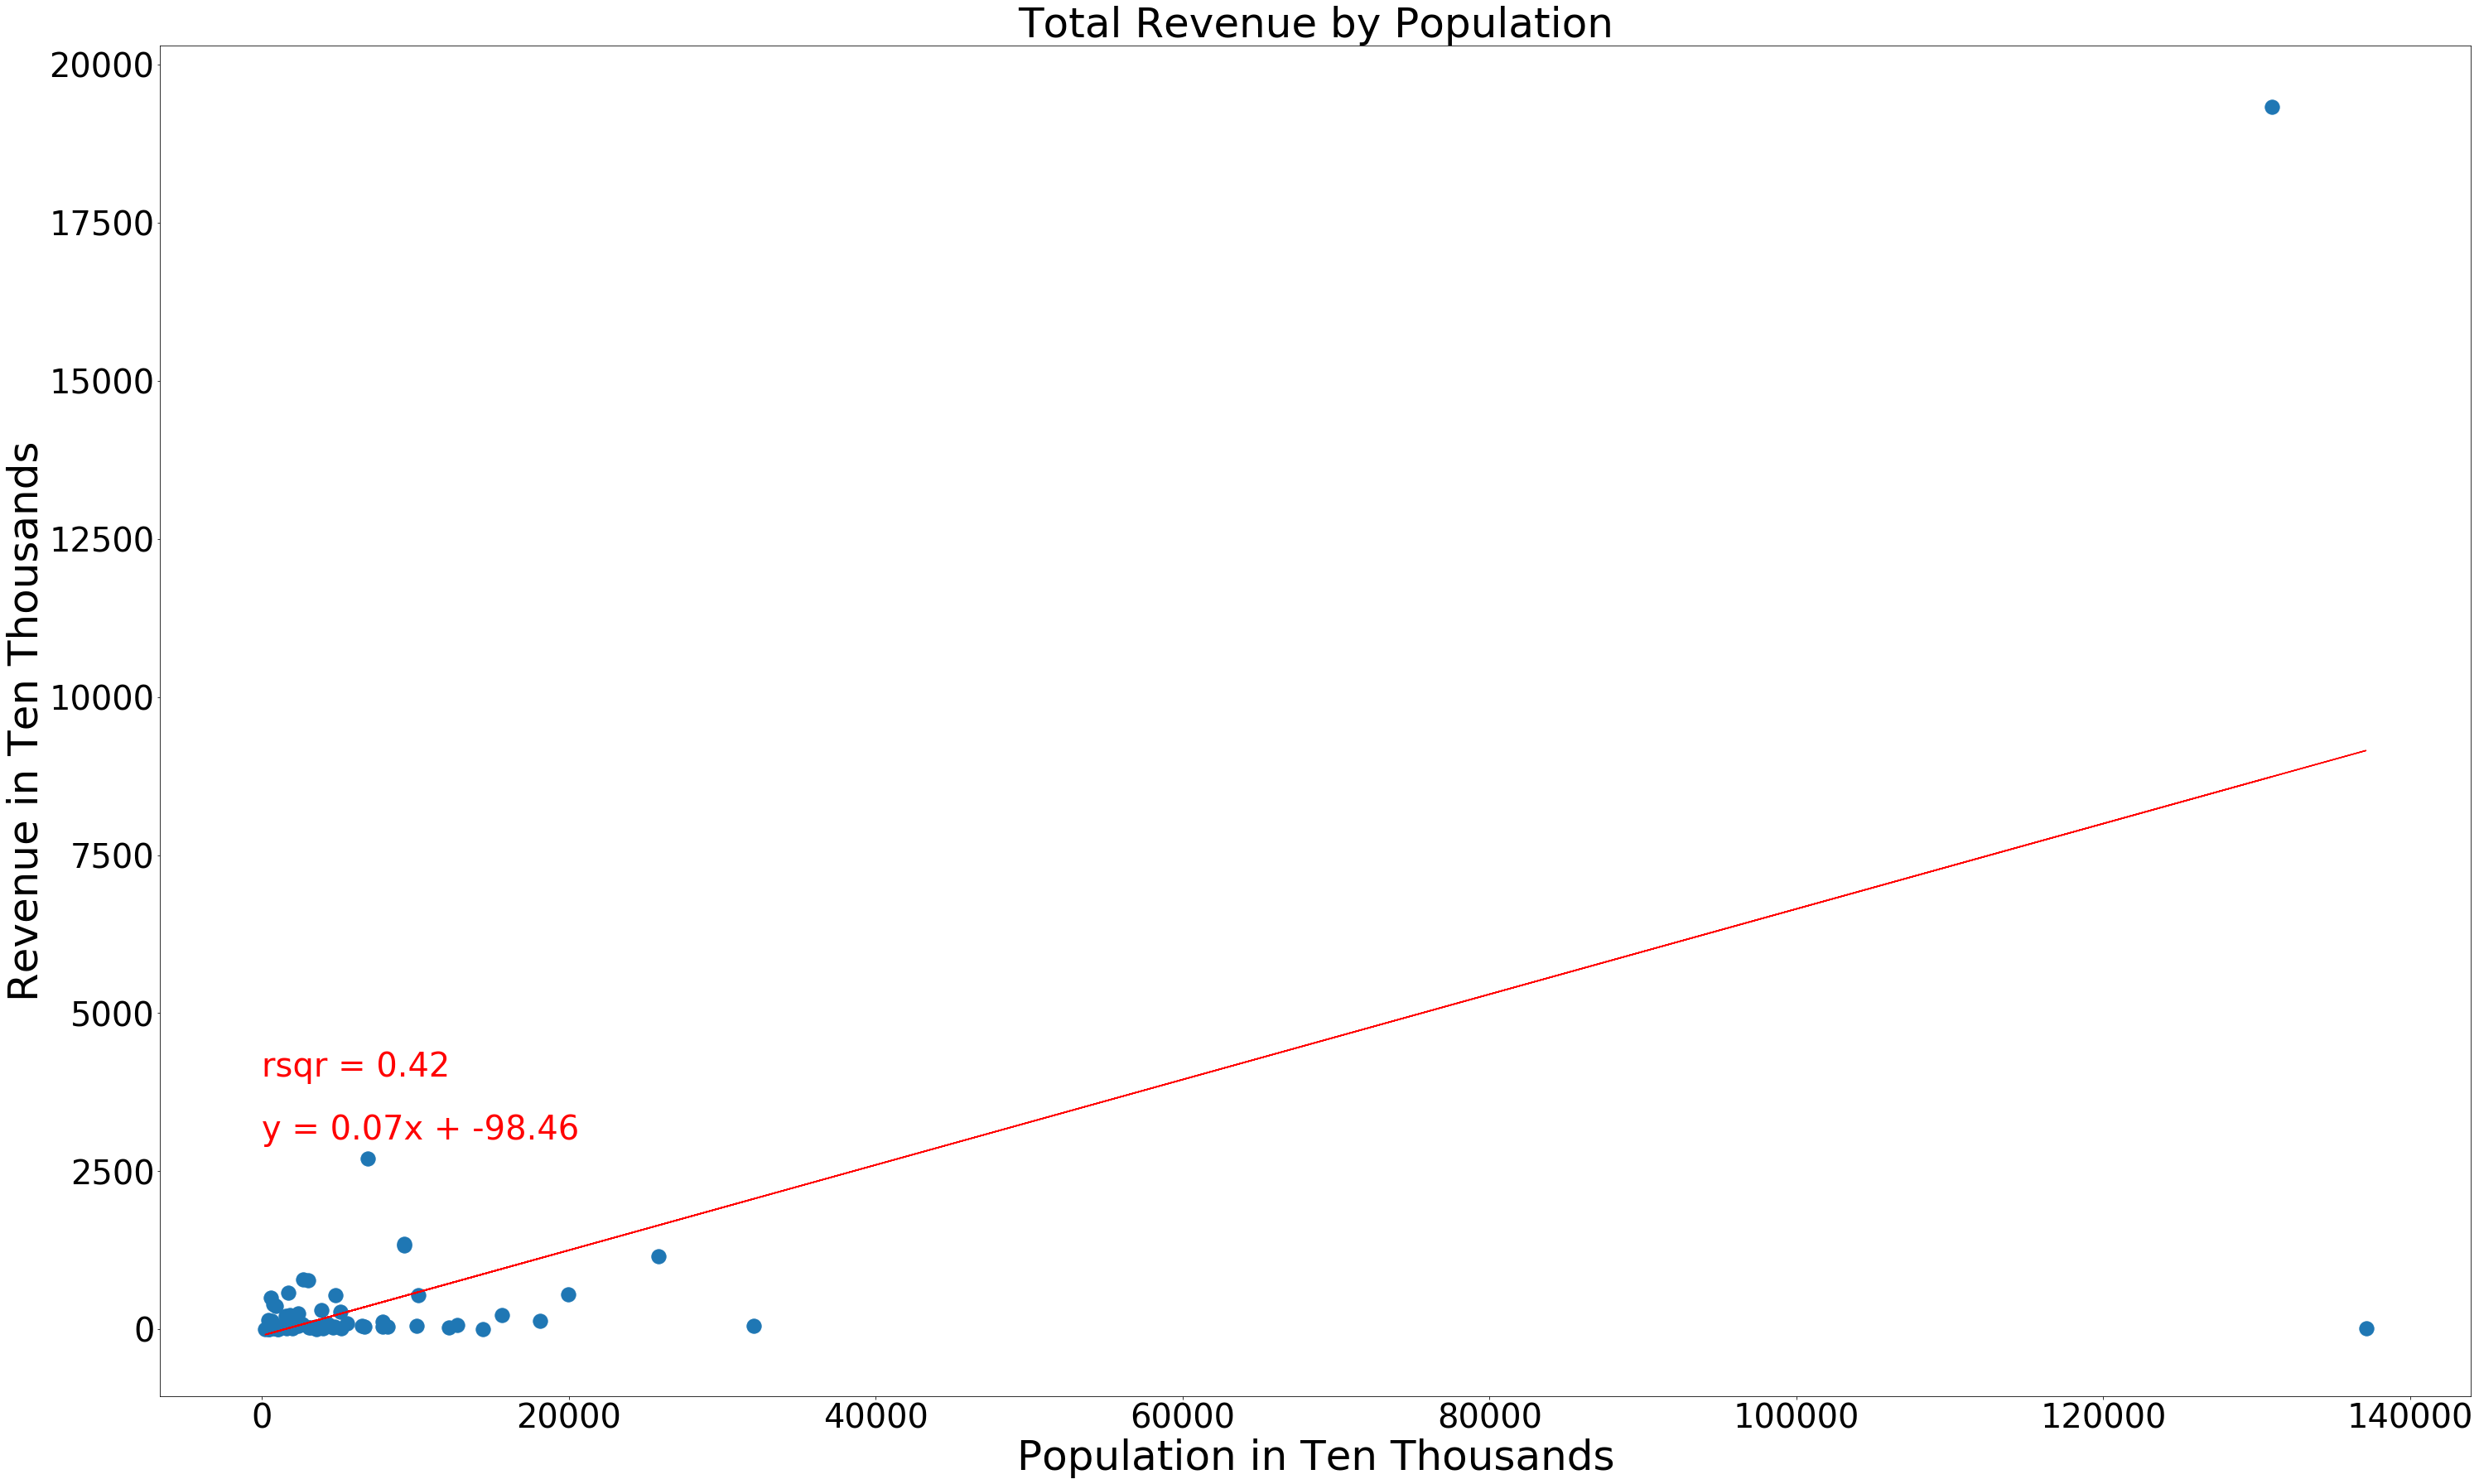

In [6]:
# remove any rows that do not have population
population_df = population_df.loc[population_df["Population"] != ""]

# add columns for displaying Revenue and Population in different scales
population_df["PopIn10000s"] = population_df["Population"]/10000
population_df["RevPer10000"] = population_df["Revenue"] / population_df["PopIn10000s"]
population_df["RevIn10000s"] = population_df["Revenue"]/10000
population_df["PopIn1000000s"] = population_df["Population"]/1000000
population_df["RevPer1000000"] = population_df["Revenue"] / population_df["PopIn1000000s"]

# set population and revenue using the 10000s as a scale
population = population_df.loc[:,"PopIn10000s"]
revenue = population_df.loc[:,"RevIn10000s"]

correlation = st.pearsonr(population,revenue)
print(f"The correlation between Population and Revenue is {round(correlation[0],2)}")

# Get the linear regression values
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(population.astype(float),revenue.astype(float))
regress_values = population * slope + intercept
# Get the regression line equation
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
rsqr = "rsqr = " + str(round(rvalue*rvalue,2))

fig = plt.figure(figsize=(50,30))
plt.scatter(population_df["PopIn10000s"],population_df["RevIn10000s"],s=300)

plt.plot(population,regress_values,"r-")
plt.annotate(line_eq,(1,3000),fontsize=40,color="red")
plt.annotate(rsqr,(1,4000),fontsize=40,color="red")

plt.title("Total Revenue by Population",fontsize=50)
plt.ylabel("Revenue in Ten Thousands",fontsize=50)
plt.xlabel("Population in Ten Thousands",fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.savefig("TotalRev.png")
plt.show()

The correlation between Population and Per Capita Revenue is -0.09


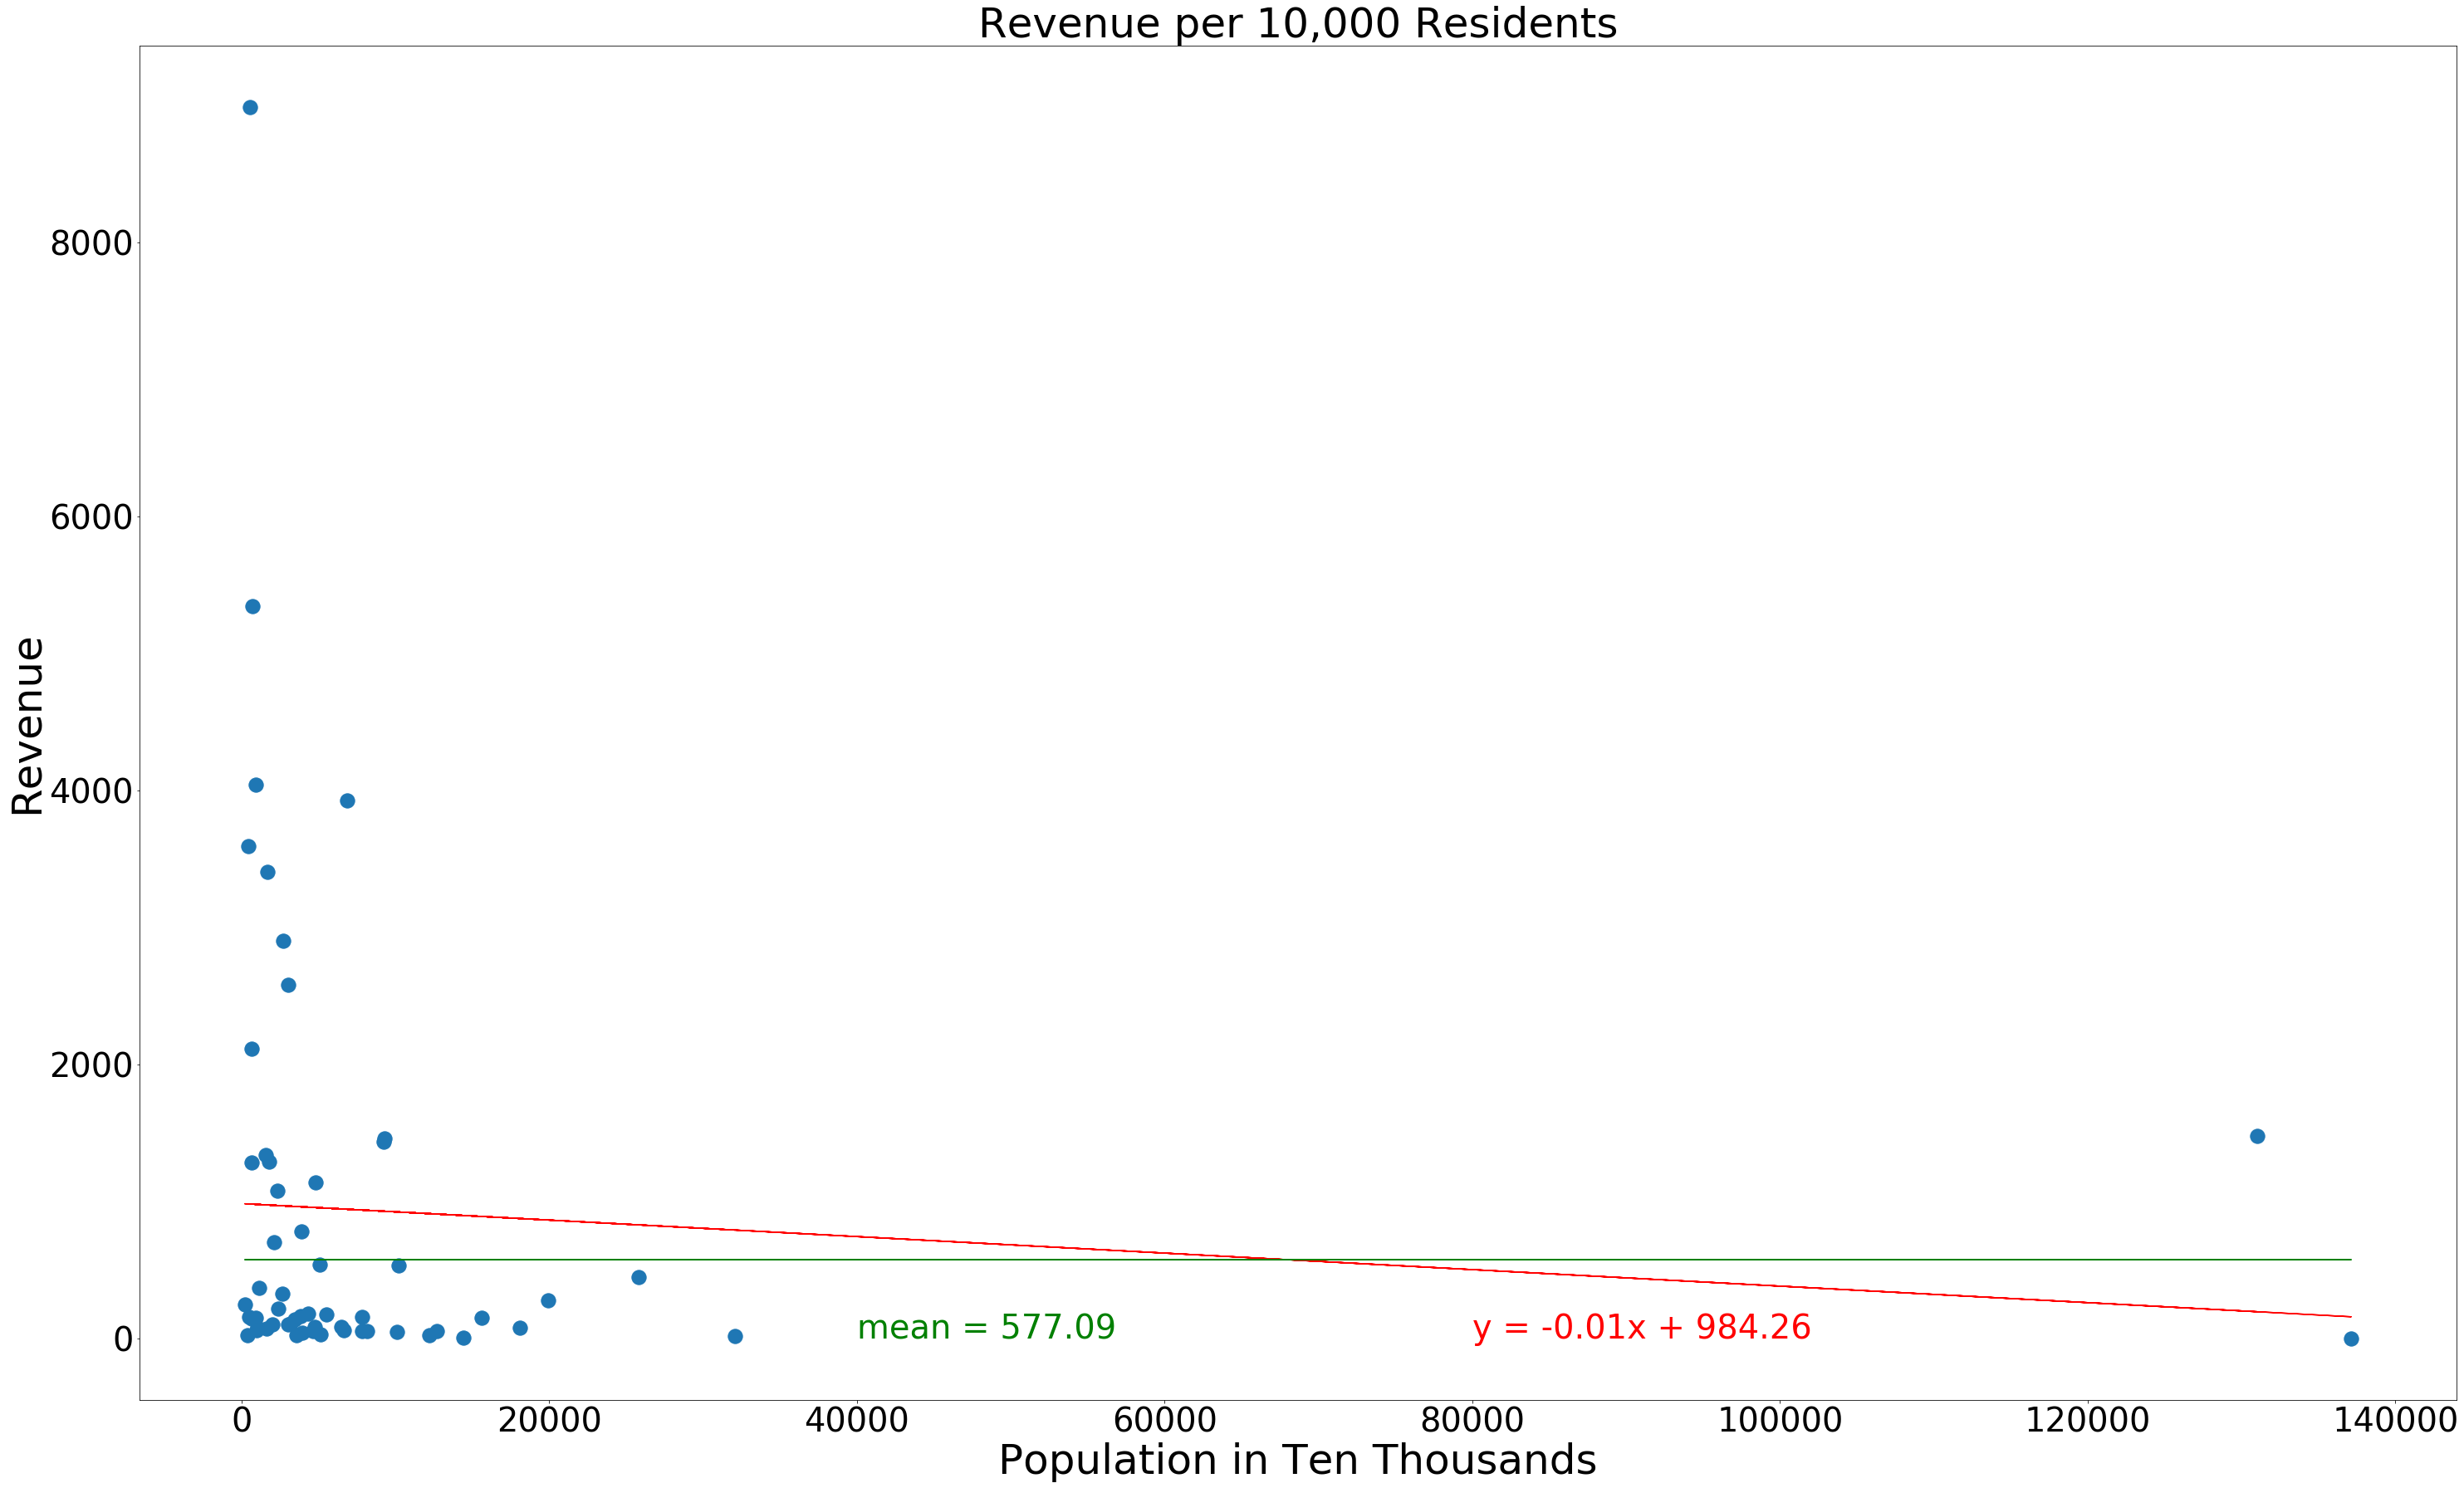

In [7]:
# set population and per capita rev to 10000s scale
population = population_df.loc[:,"PopIn10000s"]
revenue = population_df.loc[:,"RevPer10000"]

correlation = st.pearsonr(population,revenue)
print(f"The correlation between Population and Per Capita Revenue is {round(correlation[0],2)}")

# Get the linear regression values
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(population.astype(float),revenue.astype(float))
regress_values = population * slope + intercept

# calculate the mean in 10000s
per_capita_mean = population_df["Revenue"].sum()/population_df["PopIn10000s"].sum()
mean_values = population*0 + per_capita_mean
mean_label = (f"mean = {round(per_capita_mean,2)}")

# Get the regression line equation.astype(float)
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

fig = plt.figure(figsize=(50,30))
plt.scatter(population_df["PopIn10000s"],population_df["RevPer10000"],s=300)

plt.plot(population,regress_values,"r-")
plt.plot(population,mean_values,"g-")
plt.annotate(mean_label,(40000,0),fontsize=40,color="green")
plt.annotate(line_eq,(80000,0),fontsize=40,color="red")
plt.title("Revenue per 10,000 Residents",fontsize=50)
plt.ylabel("Revenue",fontsize=50)
plt.xlabel("Population in Ten Thousands",fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.savefig("RevPerCap.png")
plt.show()

The correlation between Population and Per Capita Revenue is -0.09


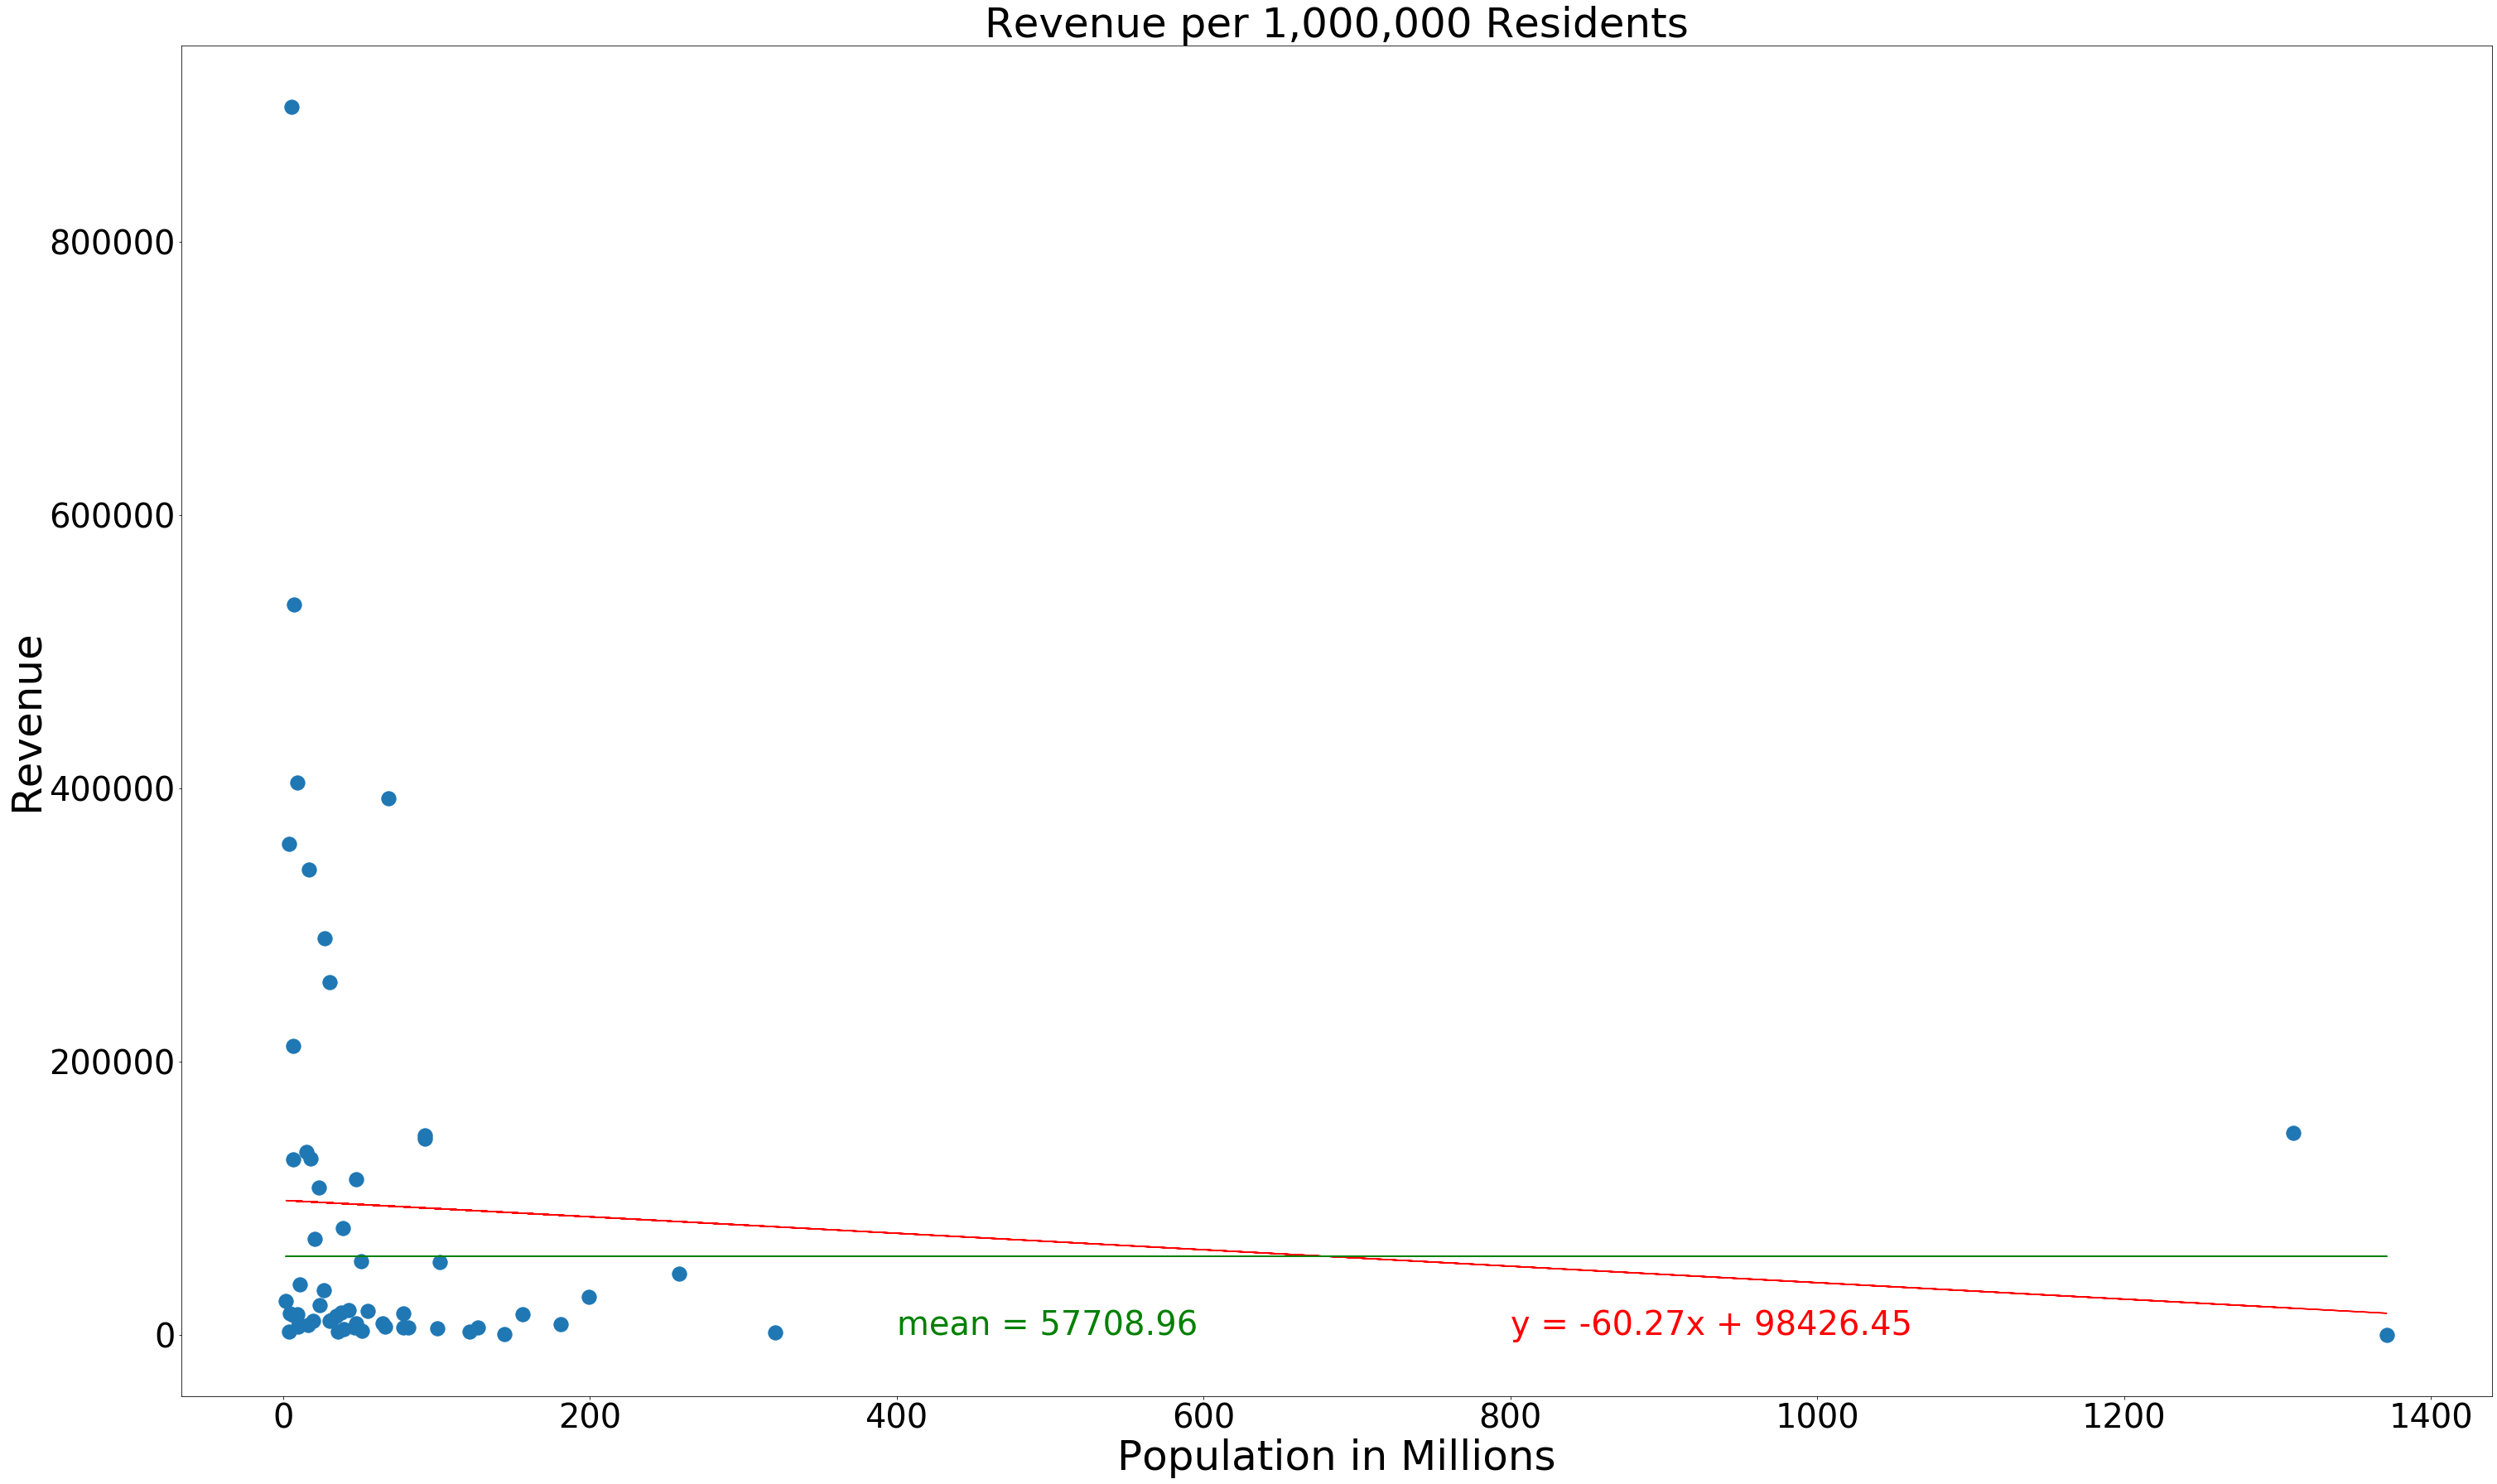

In [8]:
population2_df = population_df.copy()
population = population2_df.loc[:,"PopIn1000000s"]
revenue = population2_df.loc[:,"RevPer1000000"]

correlation = st.pearsonr(population,revenue)
print(f"The correlation between Population and Per Capita Revenue is {round(correlation[0],2)}")

# Get the linear regression values
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(population.astype(float),revenue.astype(float))
regress_values = population * slope + intercept
mean_in_millions = population2_df["Revenue"].sum()/population2_df["PopIn1000000s"].sum()
mean_values = population*0 + mean_in_millions
mean_label = (f"mean = {round(mean_in_millions,2)}")

# Get the regression line equation.astype(float)
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

fig = plt.figure(figsize=(50,30))
plt.scatter(population2_df["PopIn1000000s"],population2_df["RevPer1000000"], s=300)

plt.plot(population,regress_values,"r-")
plt.plot(population,mean_values,"g-")
plt.annotate(line_eq,(800,0),fontsize=40,color="red")
plt.annotate(mean_label,(400,0),fontsize=40,color="green")
plt.title("Revenue per 1,000,000 Residents",fontsize=50)
plt.ylabel("Revenue", fontsize=50)
plt.xlabel("Population in Millions",fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.savefig("RevPerCap2.png")
plt.show()


The correlation between Population and Revenue is 0.65


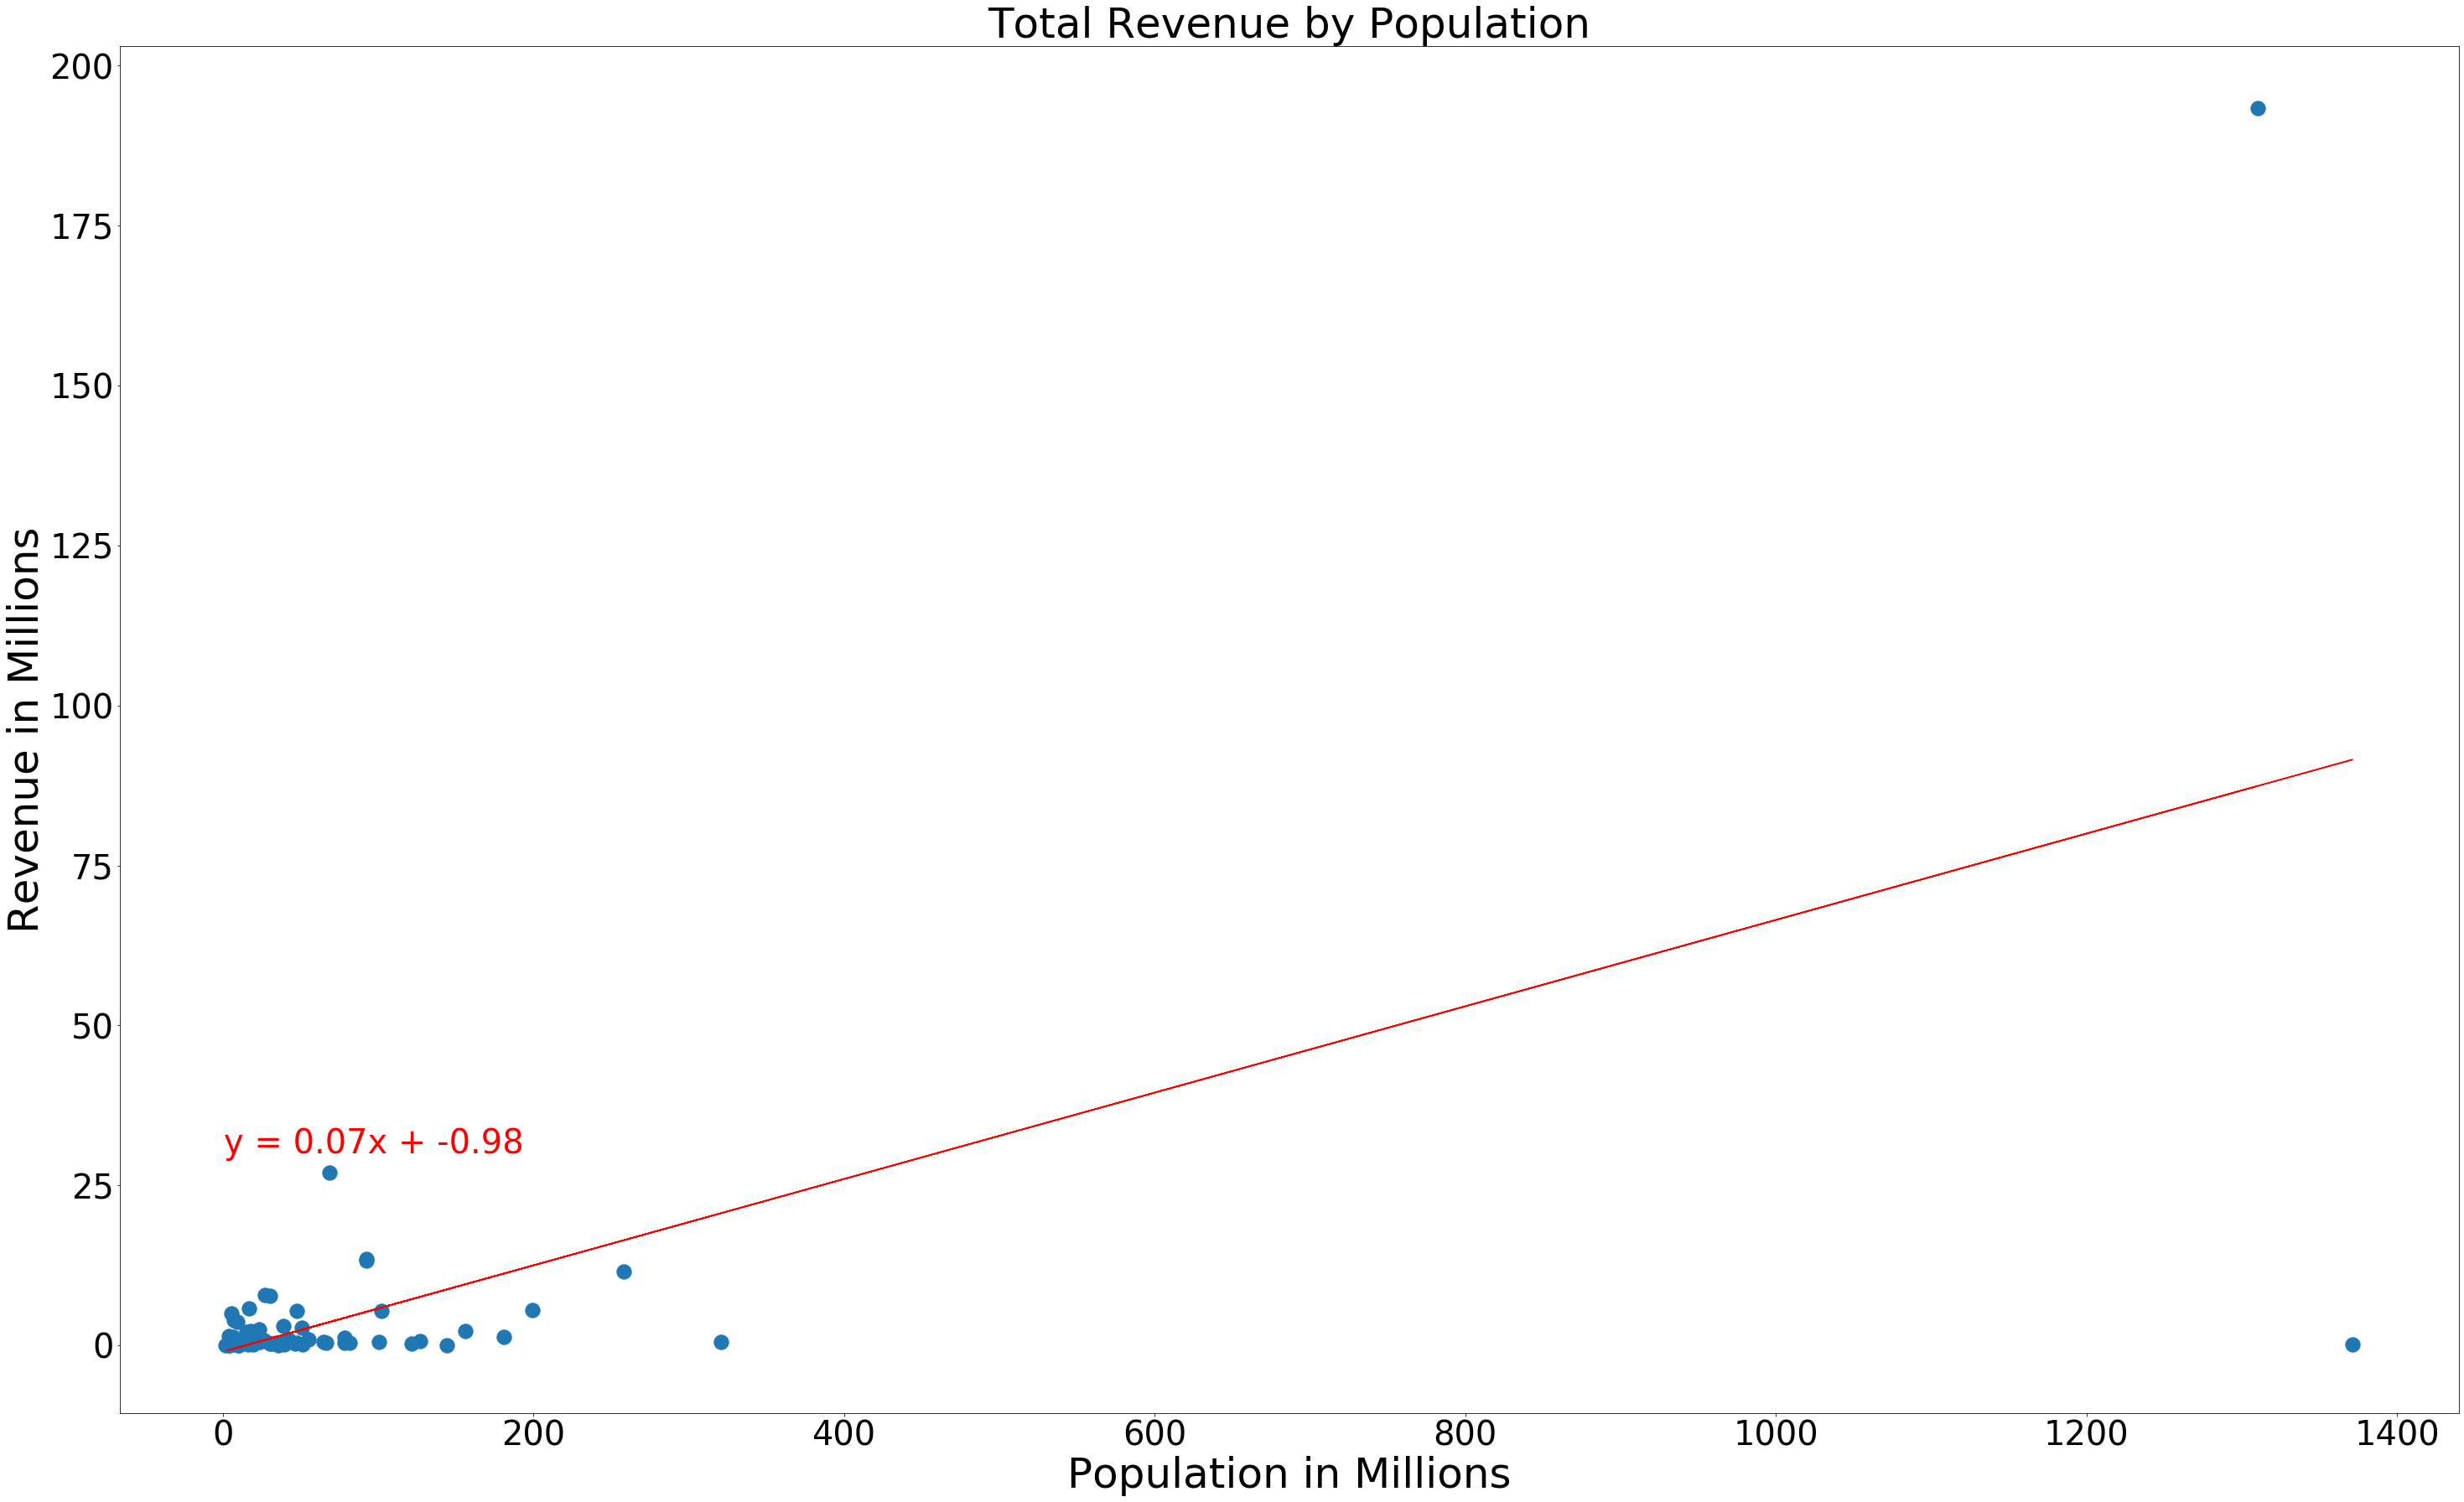

In [9]:
population = population2_df.loc[:,"PopIn1000000s"]
revenue = population2_df.loc[:,"RevIn1000000s"]

correlation = st.pearsonr(population,revenue)
print(f"The correlation between Population and Revenue is {round(correlation[0],2)}")

# Get the linear regression values
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(population.astype(float),revenue.astype(float))
regress_values = population * slope + intercept
# Get the regression line equation
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

fig = plt.figure(figsize=(50,30))
plt.scatter(population2_df["PopIn1000000s"],population_df["RevIn1000000s"], s=300)
#plt.scatter(new_df["Population"],new_df["Revenue"])

plt.plot(population,regress_values,"r-")
plt.annotate(line_eq,(1,30),fontsize=40,color="red")

plt.title("Total Revenue by Population",fontsize=50)
plt.ylabel("Revenue in Millions",fontsize=50)
plt.xlabel("Population in Millions",fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.savefig("TotalRev2.png")
plt.show()

The correlation between Population and Per Capita Revenue is -0.26


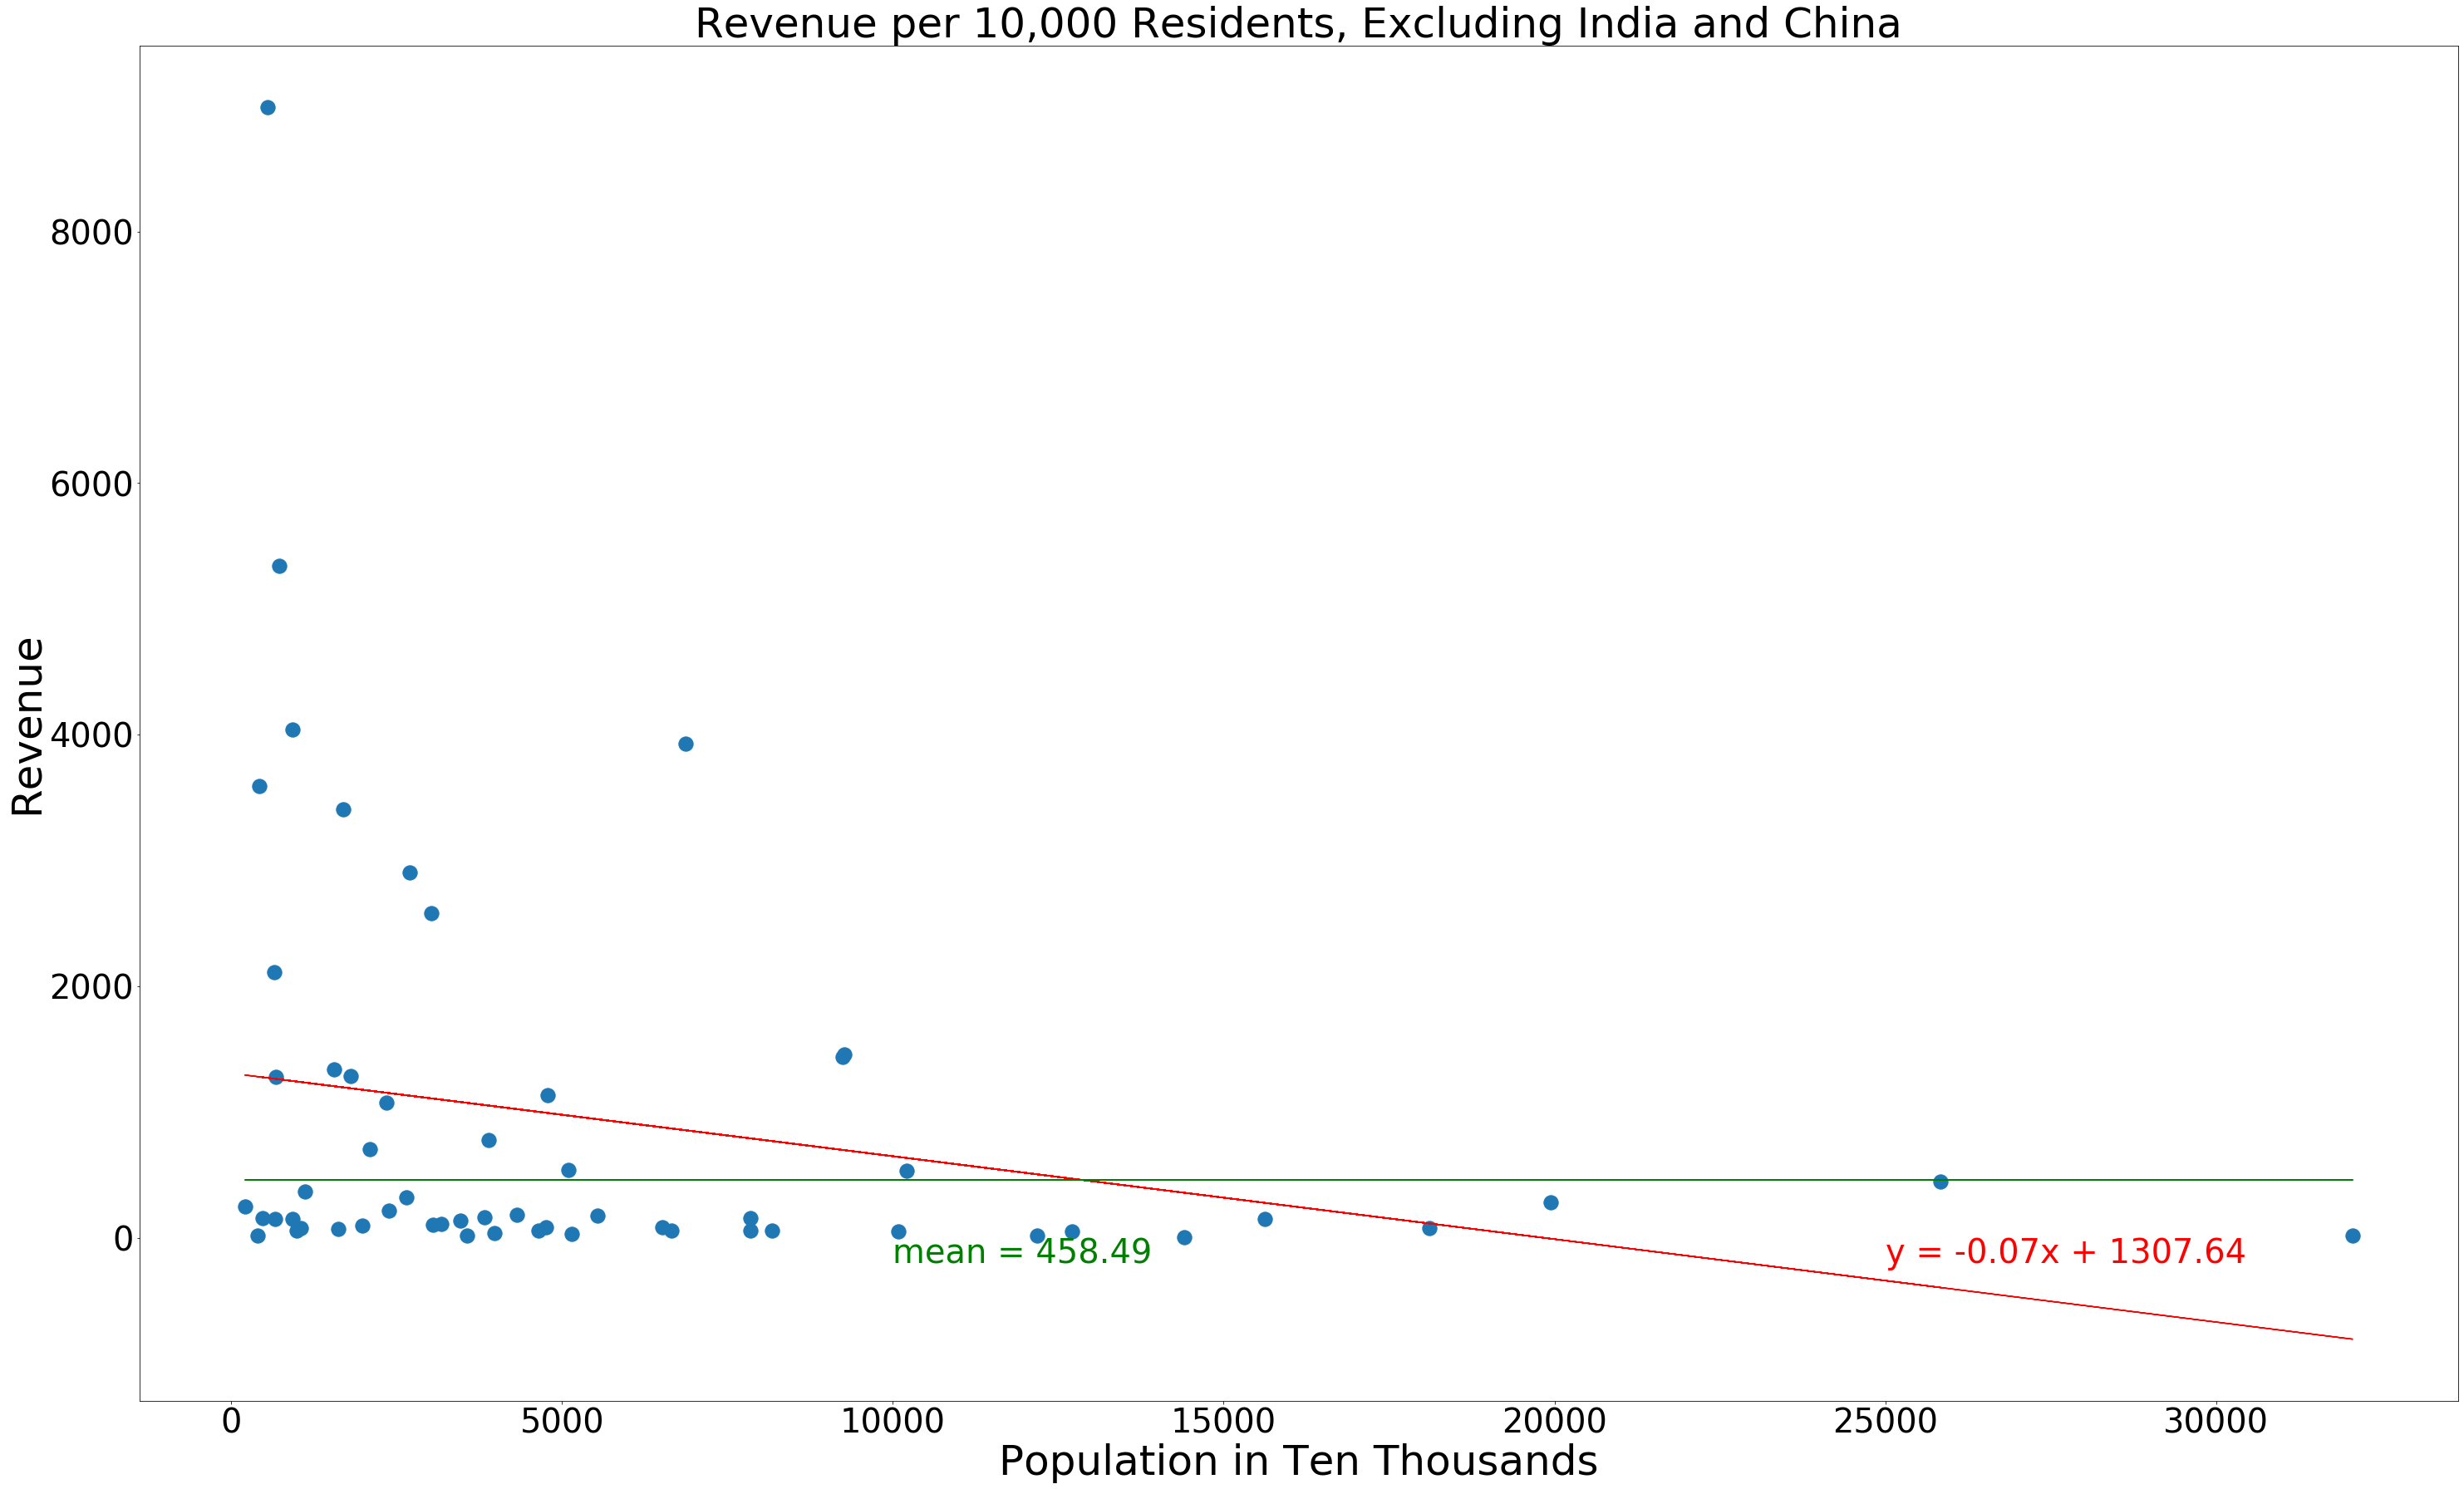

In [10]:
population3_df = population_df.copy()
population3_df = population3_df.loc[(population3_df["ship to country"] != "India") & (population3_df["ship to country"] != "China")]

population =population3_df.loc[:,"PopIn10000s"]
revenue = population3_df.loc[:,"RevPer10000"]

correlation = st.pearsonr(population,revenue)
print(f"The correlation between Population and Per Capita Revenue is {round(correlation[0],2)}")

# Get the linear regression values
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(population.astype(float),revenue.astype(float))
regress_values = population * slope + intercept
mean_in_millions = population3_df["Revenue"].sum()/population3_df["PopIn10000s"].sum()
mean_values = population*0 + mean_in_millions
mean_label = (f"mean = {round(mean_in_millions,2)}")

# Get the regression line equation.astype(float)
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

fig = plt.figure(figsize=(50,30))
plt.scatter(population3_df["PopIn10000s"],population3_df["RevPer10000"],s=300)

plt.plot(population,regress_values,"r-")
plt.plot(population,mean_values,"g-")
plt.annotate(line_eq,(25000,-200),fontsize=40,color="red")
plt.annotate(mean_label,(10000,-200),fontsize=40,color="green")
plt.title("Revenue per 10,000 Residents, Excluding India and China",fontsize=50)
plt.ylabel("Revenue",fontsize=50)
plt.xlabel("Population in Ten Thousands",fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.savefig("RevPerCap3.png")
plt.show()


The correlation between Population and Revenue is 0.19


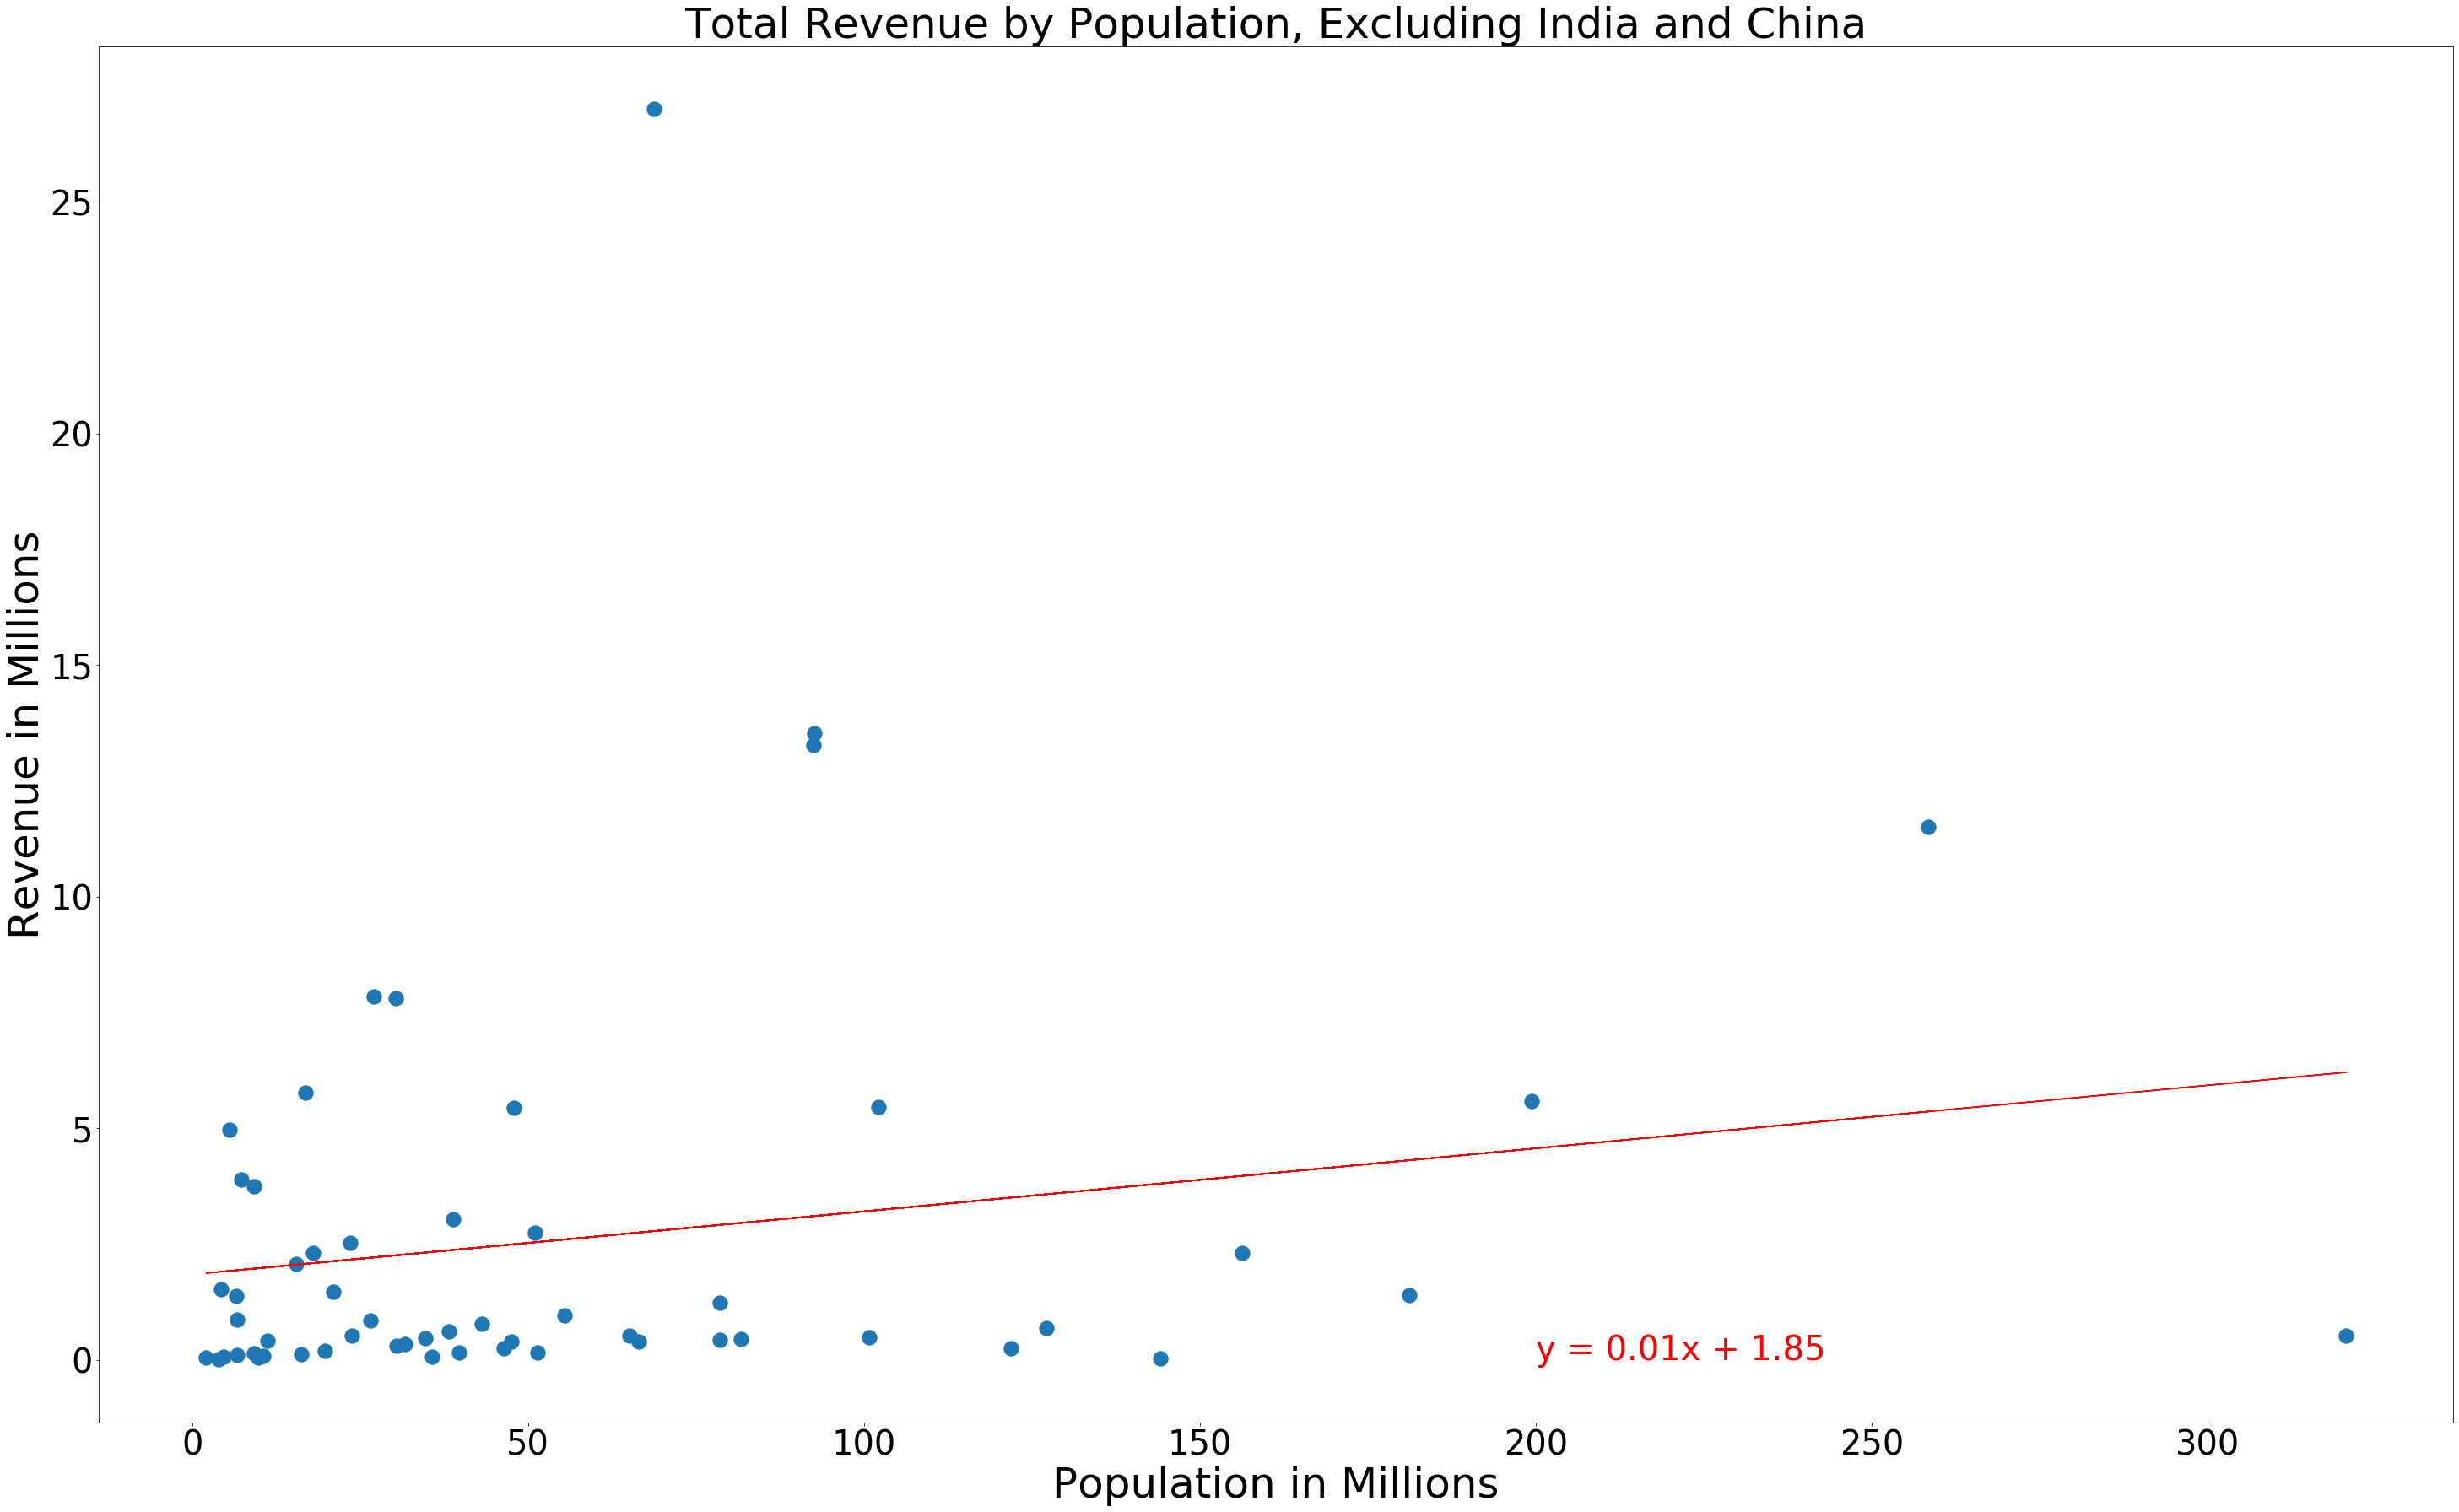

In [11]:
population = population3_df.loc[:,"PopIn1000000s"]
revenue = population3_df.loc[:,"RevIn1000000s"]

correlation = st.pearsonr(population,revenue)
print(f"The correlation between Population and Revenue is {round(correlation[0],2)}")

# Get the linear regression values
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(population.astype(float),revenue.astype(float))
regress_values = population * slope + intercept
# Get the regression line equation
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

fig = plt.figure(figsize=(50,30))
plt.scatter(population3_df["PopIn1000000s"],population3_df["RevIn1000000s"],s=300)
#plt.scatter(new_df["Population"],new_df["Revenue"])

plt.plot(population,regress_values,"r-")
plt.annotate(line_eq,(200,0),fontsize=40,color="red")

plt.title("Total Revenue by Population, Excluding India and China",fontsize=50)
plt.ylabel("Revenue in Millions",fontsize=50)
plt.xlabel("Population in Millions",fontsize=50)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.savefig("TotalRev3.png")
plt.show()

In [12]:
# Show the countries that have lower imports than the mean ordered by Population descending, excludes China and India
below_mean_df = population3_df.loc[population3_df["Revenue"].sum()/population3_df["Population"].sum()*1000000 > population3_df["RevPer1000000"]]
below_mean_df = below_mean_df[["ship to country","Revenue","Population","RevPer10000"]]
below_mean_df.sort_values("Population",ascending=False,inplace=True)
below_mean_df.reset_index(drop=True,inplace=True)
below_mean_df.rename(columns={"ship to country":"Country"},inplace=True)
below_mean_df

,Country,Revenue,Population,RevPer10000
0,USA,529602,320635163,16.5173
1,Indonesia,11510346,258383256,445.476
2,Pakistan,5594622,199426964,280.535
3,Nigeria,1391229,181137448,76.8052
4,Bangladesh,2307584,156256276,147.679
5,Russian Fed.,28500,144096870,1.97784
6,Japan,682695,127141000,53.6959
7,Mexico,251631,121858258,20.6495
8,Ethiopia,493798,100835458,48.9707
9,Germany,455278,81686611,55.7347


In [13]:
# Show the countries that have lower imports than the mean ordered by Revenue Per 10,000 ascending
below_mean_all_df = population2_df.loc[population2_df["Revenue"].sum()/population2_df["Population"].sum()*1000000 > population2_df["RevPer1000000"]]
below_mean_all_df = below_mean_all_df[["ship to country","Revenue","Population","RevPer10000"]]
below_mean_all_df.sort_values("RevPer10000",ascending=True,inplace=True)
below_mean_all_df.reset_index(drop=True,inplace=True)
below_mean_all_df.rename(columns={"ship to country":"Country"},inplace=True)
below_mean_all_df

,Country,Revenue,Population,RevPer10000
0,China,120930,1371220000,0.881915
1,Russian Fed.,28500,144096870,1.97784
2,USA,529602,320635163,16.5173
3,Canada,72160,35702908,20.2112
4,Panama,8052,3968487,20.2898
5,Mexico,251631,121858258,20.6495
6,Tanzania,155873,51482633,30.2768
7,Algeria,160308,39728025,40.3514
8,Ethiopia,493798,100835458,48.9707
9,Japan,682695,127141000,53.6959


In [14]:
# Show the countries that have higher imports than the mean ordered by Revenue per 10,000 ascending, excludes China and India
over_mean_df = population3_df.loc[population3_df["Revenue"].sum()/population3_df["Population"].sum()*1000000 < population3_df["RevPer1000000"]]
over_mean_df = over_mean_df[["ship to country","Revenue","Population","RevPer10000"]]
over_mean_df.sort_values("RevPer10000",inplace=True)
over_mean_df.reset_index(drop=True,inplace=True)
over_mean_df.rename(columns={"ship to country":"Country"},inplace=True)
over_mean_df

,Country,Revenue,Population,RevPer10000
0,Philippines,5456271,102113212,534.335
1,South Korea,2753439,51014947,539.732
2,Sri Lanka,1477015,20970000,704.347
3,Sudan,3036276,38902950,780.474
4,Taiwan,2527356,23492000,1075.84
5,Kenya,5444711,47878336,1137.2
6,Laos,863965,6741164,1281.63
7,Syria,2317088,17997408,1287.46
8,Cambodia,2080242,15521436,1340.24
9,Egypt,13278208,92442547,1436.37


In [15]:
# Show the countries that have higher imports than the mean ordered by Revenue per 10,000 descending
over_mean_all_df = population2_df.loc[population2_df["Revenue"].sum()/population2_df["Population"].sum()*1000000 < population2_df["RevPer1000000"]]
over_mean_all_df = over_mean_all_df[["ship to country","Revenue","Population","RevPer10000"]]
over_mean_all_df.sort_values("RevPer10000",ascending=False,inplace=True)
over_mean_all_df.reset_index(drop=True,inplace=True)
over_mean_all_df.rename(columns={"ship to country":"Country"},inplace=True)
over_mean_all_df

,Country,Revenue,Population,RevPer10000
0,Singapore,4975063,5535002,8988.37
1,Hong Kong,3896386,7291300,5343.88
2,Utd.Arab Emir.,3744946,9262900,4042.95
3,Thailand,27003115,68714511,3929.75
4,Oman,1533925,4267348,3594.56
5,Netherlands,5767851,16939923,3404.89
6,Nepal,7842394,27015031,2902.97
7,Malaysia,7805616,30270962,2578.58
8,Lebanon,1381137,6532678,2114.2
9,India,193340264,1310152403,1475.71


In [16]:
# Show all countries and total revenue sorted by Total Revenue descending
country_rev_df = population_df.loc[:,["ship to country","Revenue"]]
country_rev_df.sort_values("Revenue", ascending=False,inplace=True)
country_rev_df.reset_index(drop=True,inplace=True)
country_rev_df.rename(columns={"ship to country":"Country"},inplace=True)
country_rev_df

,Country,Revenue
0,India,193340264
1,Thailand,27003115
2,Vietnam,13522609
3,Egypt,13278208
4,Indonesia,11510346
5,Nepal,7842394
6,Malaysia,7805616
7,Netherlands,5767851
8,Pakistan,5594622
9,Philippines,5456271


In [17]:
# Calculate the difference from the mean revenue for countries with 100,000,000 population and less than mean revenue
per_capita_mean = population_df["Revenue"].sum()/population_df["PopIn10000s"].sum()
below_mean_all2_df = below_mean_all_df.copy()
below_mean_all2_df.sort_values("Population", ascending=False,inplace=True)
targets_df = below_mean_all2_df.loc[below_mean_all2_df["Population"]>100000000].copy()
targets_df["MeanPer10000"] = per_capita_mean
targets_df["RevGapFromMean"] = per_capita_mean - targets_df["RevPer10000"]
targets_df["PotentialRevenueInMillions"] = (targets_df["RevGapFromMean"] * (targets_df["Population"]/10000))/1000000
targets_df.sort_values("PotentialRevenueInMillions", ascending=False,inplace=True)
targets_df["PotentialPercentGain"] = targets_df["PotentialRevenueInMillions"]*1000000 / targets_df["Revenue"] *100
targets_df

,Country,Revenue,Population,RevPer10000,MeanPer10000,RevGapFromMean,PotentialRevenueInMillions,PotentialPercentGain
0,China,120930,1371220000,0.881915,577.089634,576.208,79.0108,65335.9
2,USA,529602,320635163,16.5173,577.089634,560.572,17.9739,3393.85
16,Nigeria,1391229,181137448,76.8052,577.089634,500.284,9.06203,651.368
1,Russian Fed.,28500,144096870,1.97784,577.089634,575.112,8.28718,29077.8
5,Mexico,251631,121858258,20.6495,577.089634,556.44,6.78068,2694.69
25,Bangladesh,2307584,156256276,147.679,577.089634,429.41,6.7098,290.772
9,Japan,682695,127141000,53.6959,577.089634,523.394,6.65448,974.737
34,Pakistan,5594622,199426964,280.535,577.089634,296.555,5.9141,105.71
8,Ethiopia,493798,100835458,48.9707,577.089634,528.119,5.32531,1078.44
37,Indonesia,11510346,258383256,445.476,577.089634,131.614,3.40068,29.5446


In [18]:
target2_df = targets_df[["Country","Population","RevPer10000"]]
target2_df

,Country,Population,RevPer10000
0,China,1371220000,0.881915
2,USA,320635163,16.5173
16,Nigeria,181137448,76.8052
1,Russian Fed.,144096870,1.97784
5,Mexico,121858258,20.6495
25,Bangladesh,156256276,147.679
9,Japan,127141000,53.6959
34,Pakistan,199426964,280.535
8,Ethiopia,100835458,48.9707
37,Indonesia,258383256,445.476


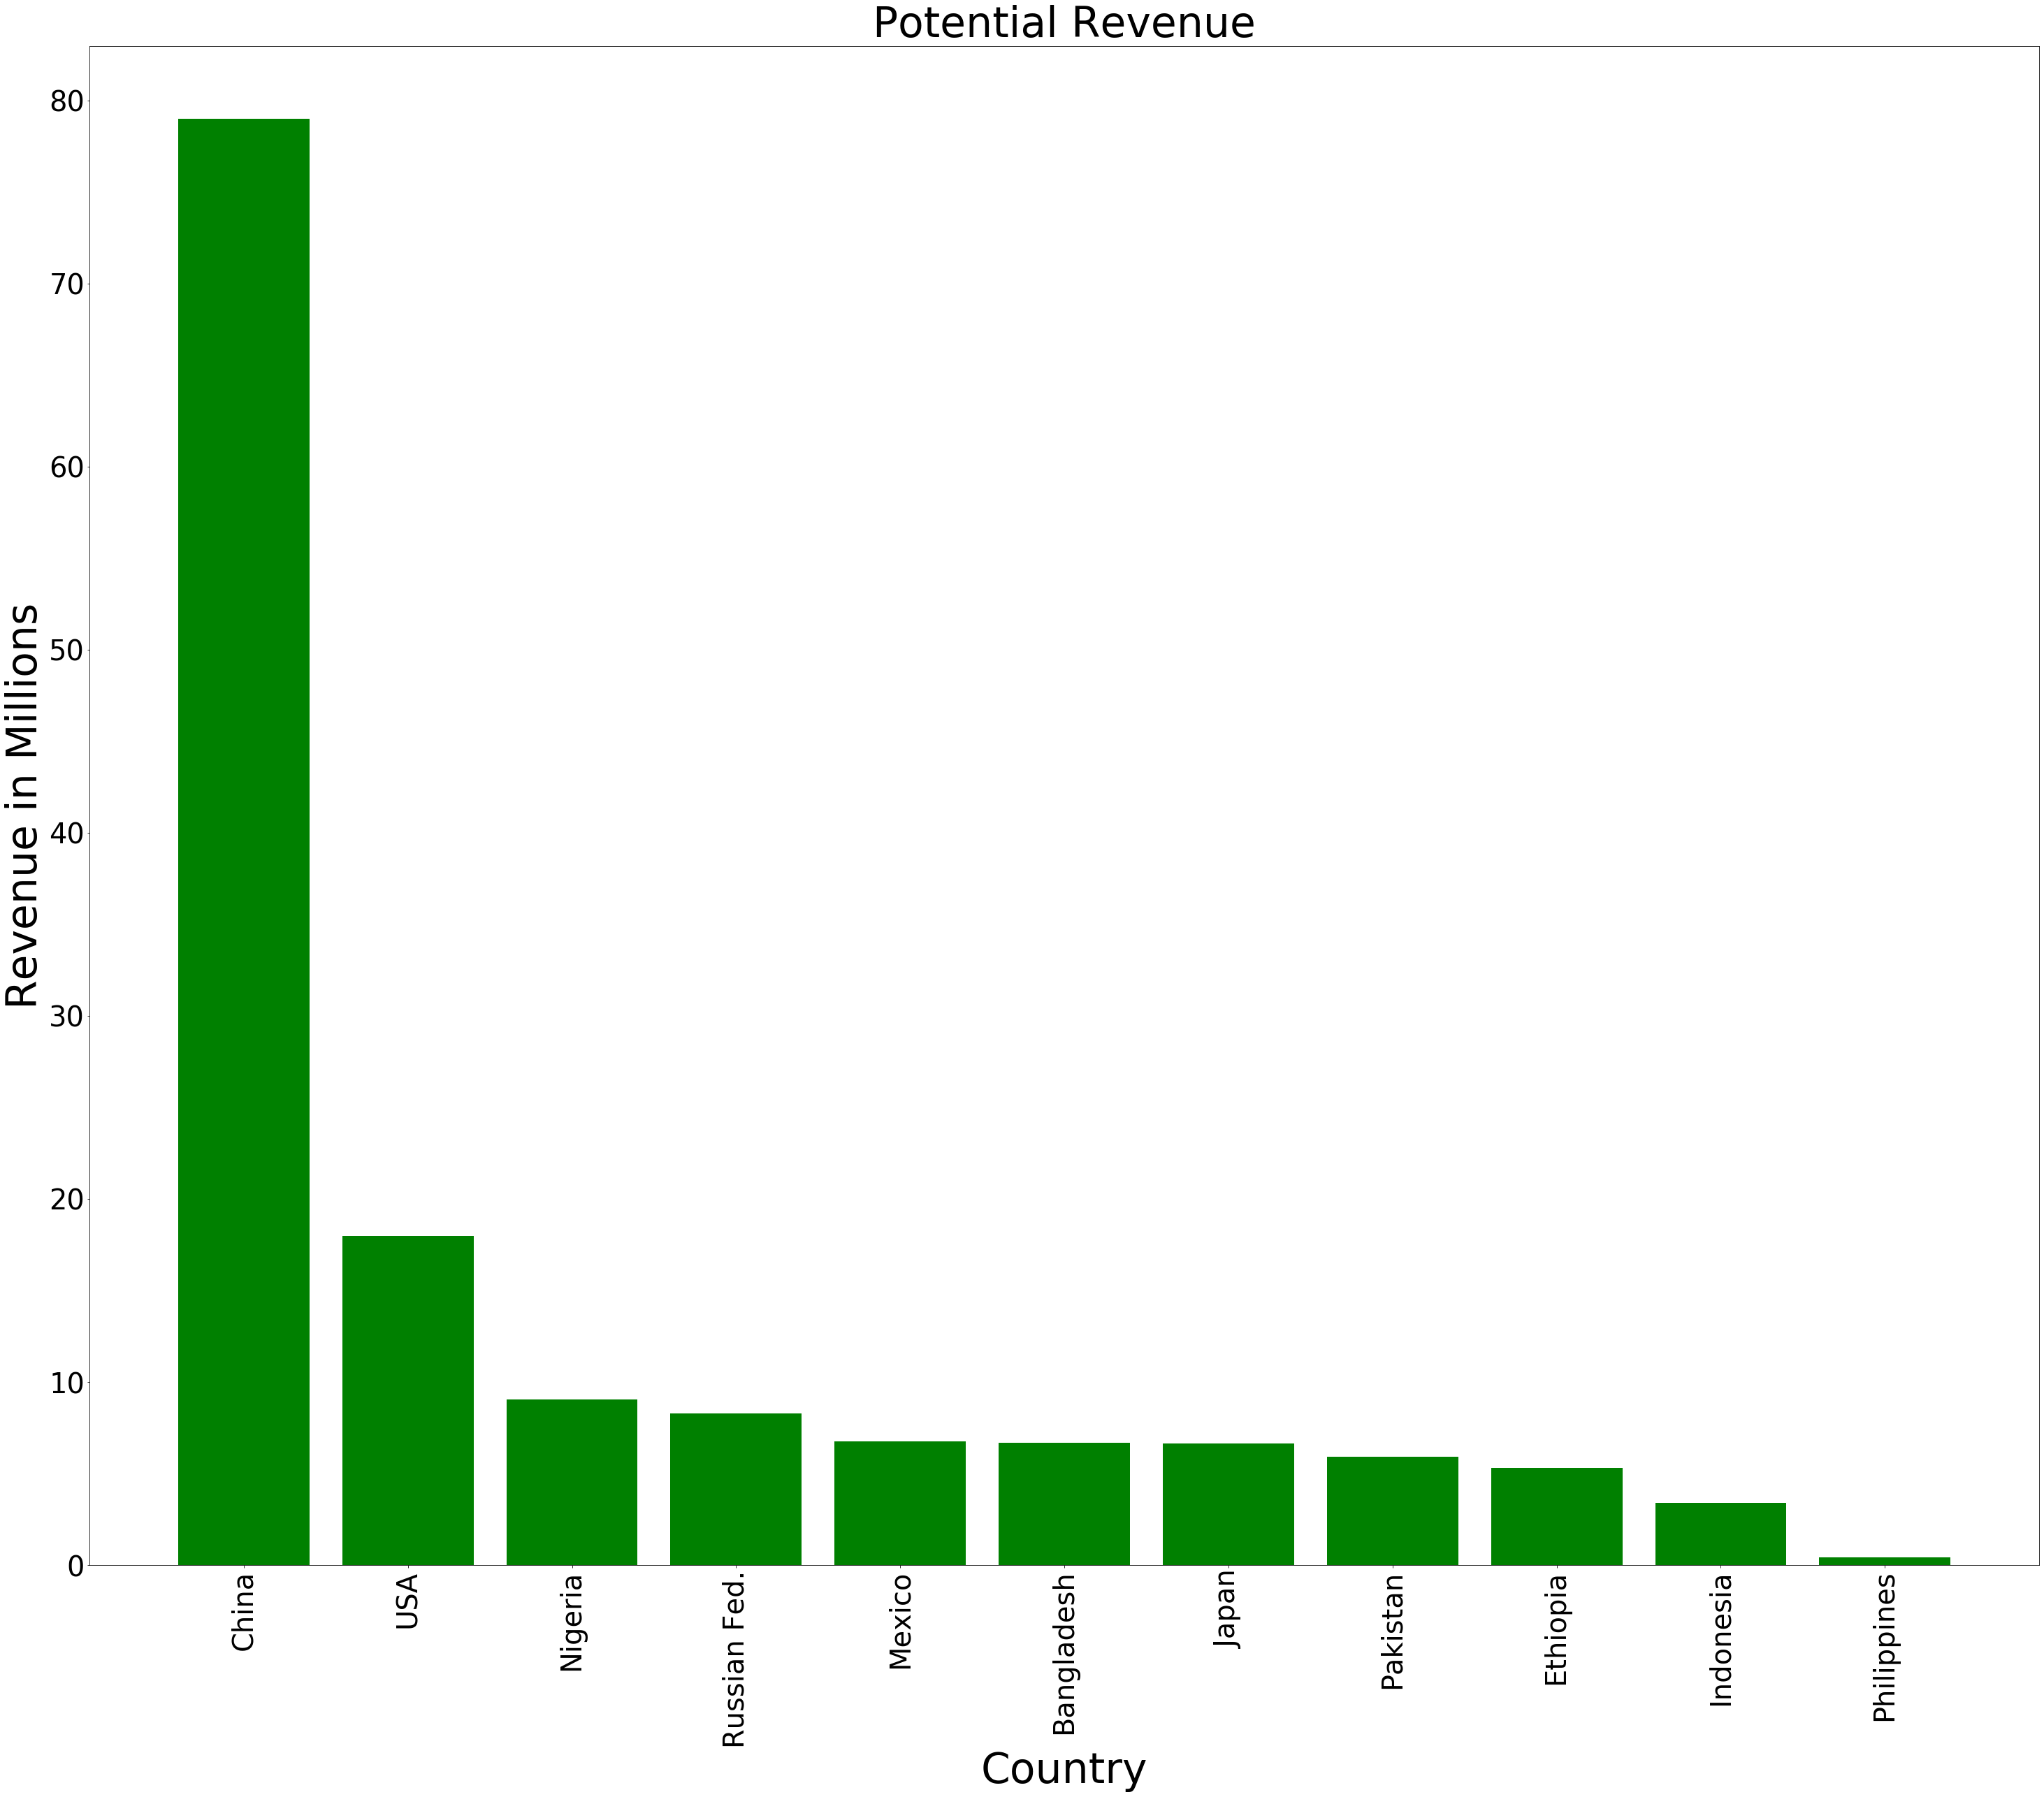

In [19]:
# Bar chart to show the Potential Revenue of the targeted countries
fig = plt.figure(figsize=(50,40))
plt.bar(targets_df["Country"],targets_df["PotentialRevenueInMillions"],color="green")
plt.title("Potential Revenue",fontsize=60)
plt.ylabel("Revenue in Millions",fontsize=60)
plt.xlabel("Country",fontsize=60)
plt.xticks(rotation=90,fontsize=40)
plt.yticks(fontsize=40)
plt.savefig("PotentialRev.png")
plt.show()